# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 9: Regression Trees, Bagged Trees, Random Forests and Boosting

**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors:** Pavlos Protopapas and Kevin Rader<br/>
**Lab Instructor:** Kevin Rader (today at least)<br/>
**Authors:** Kevin Rader, Rahul Dave

---
We will look here into the practicalities of fitting regression trees, random forests, and boosted trees. These involve out-of-bound estmates and cross-validation, and how you might want to deal with hyperparameters in these models. Along the way we will play a little bit with different loss functions, so that you start thinking about what goes in general into cooking up a machine learning model.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Dataset

First, the data. We will be attempting to predict the presidential election results (at the county level) from 2016, measured as 'votergap' = (trump - clinton) in percentage points, based mostly on demographic features of those counties.  Let's quick take a peak at the data:

In [2]:
elect_df = pd.read_csv("county_level_election.csv")
elect_df.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# split 80/20 train-test
X = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,response,test_size=0.2)


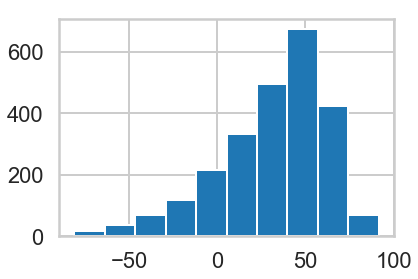

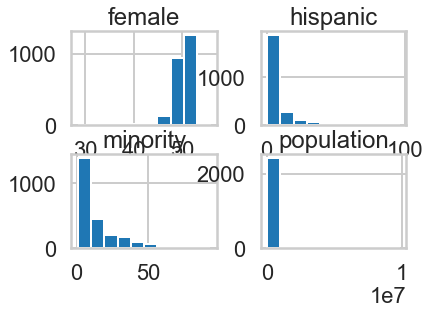

In [6]:
plt.hist(ytrain)
Xtrain.hist(column=['minority', 'population','hispanic','female']);

How would you describe these variables?

In [7]:
print(elect_df.shape)
print(Xtrain.shape)
print(Xtest.shape)

(3066, 18)
(2452, 12)
(614, 12)


## Regression Trees

We will start by using a simple Decision Tree Regressor to predict votergap. Thats not the aim of this lab, so we'll run a few of these models without any cross-validation or 'regularization' just to illustrate what is going on.

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

In [8]:
from sklearn.tree import DecisionTreeRegressor
#x = np.arange(0, 2*np.pi, 0.1)
#y = np.sin(x) + 0.1*np.random.normal(size=x.shape[0])
x = Xtrain['minority'].values
o = np.argsort(x)
x = x[o]
y = ytrain.values
y = y[o]


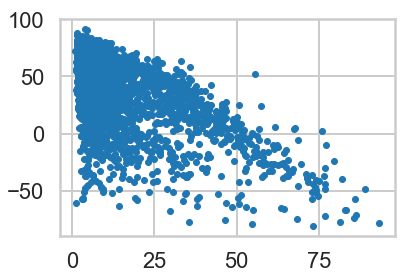

In [9]:
plt.plot(x,y, '.');

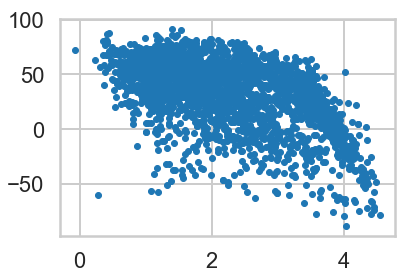

In [10]:
plt.plot(np.log(x),y, '.');

<div class="exercise">**Exercise 0**</div>
Which of the two versions of 'minority' would be a better choice to use as a predictor for inference?  For prediction?

<hr style='height:2px'>

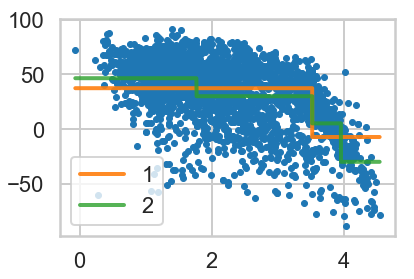

In [11]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [1,2]: # depth
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=1-i/10, lw=4)
plt.legend();

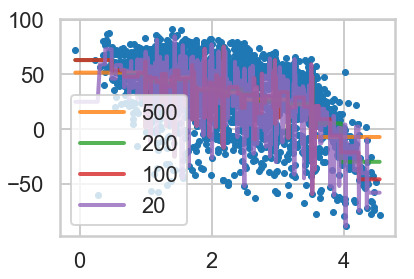

In [12]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]: # hyperparameter (sample size in the sub-regions)
    dtree = DecisionTreeRegressor(min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

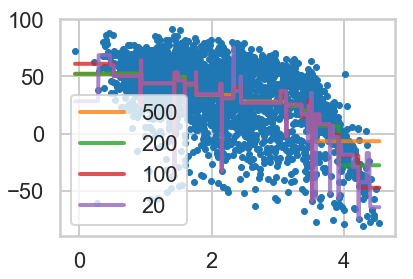

In [10]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]:
    dtree = DecisionTreeRegressor(max_depth=6, min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

In [32]:
#let's also include logminority as a predictor going forward
xtemp = np.log(Xtrain['minority'].values)
Xtrain = Xtrain.assign(logminority = xtemp)
Xtest = Xtest.assign(logminority = np.log(Xtest['minority'].values))
Xtrain.head()


,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,logminority
803,69380,14.133,7.583,50.690,6.0,36241,26.9,11.3,30.4,30.4,91.5,195.7,2.025909
393,6922,2.946,4.282,50.661,3.6,49345,9.7,16.5,29.2,31.0,47.6,163.6,1.454420
163,498894,7.256,13.634,50.798,3.7,85613,7.2,48.8,17.1,23.0,138.7,135.8,2.612567
1009,24400,1.279,4.692,48.334,6.6,34581,27.0,7.8,31.8,33.6,75.9,206.3,1.545859
1606,21538,22.932,8.222,49.936,4.5,51508,16.4,13.2,26.8,31.1,102.5,233.1,2.106813


<div class="exercise">**Exercise 1**</div>

1. Perform 5-fold cross-validation to determine what the best `max_depth` would be for a single regression tree using the entire 'Xtrain' feature set.

2. Visualize the results with mean +/- 2 sd's across the validation sets.

In [29]:
from sklearn.model_selection import cross_val_score

# your code here
depths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []
cv_scores = []
for depth in depths:
    dtree = DecisionTreeRegressor(max_depth=depth)
    # Perform 5-fold cross validation and store results
    cv_scores = cross_val_score(dtree, Xtrain,ytrain,cv=5)
    cvmeans.append(cv_scores.mean())
    cvstds.append(cv_scores.std())
    train_scores.append(dtree.fit(Xtrain, ytrain).score(Xtrain,ytrain))
    print(cv_scores)
#     cvmeans = cv_scores.append(cv_scores.mean())
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

[0.22905717 0.18181331 0.23449012 0.22607538 0.18546352]
[0.42443974 0.39529339 0.47066632 0.41027821 0.41106218]
[0.51171438 0.55839917 0.4442907  0.52539255 0.5260225 ]
[0.56459502 0.6069394  0.48484485 0.6086625  0.59549533]
[0.60866994 0.65645981 0.52214853 0.641972   0.63926567]
[0.62811636 0.63974906 0.54488651 0.64396771 0.64888072]
[0.61539721 0.64699074 0.55090227 0.62478311 0.65468458]
[0.62995005 0.66250802 0.55214824 0.64156861 0.63797915]
[0.64954786 0.61922378 0.52914633 0.61752171 0.63776076]
[0.63550773 0.6245867  0.49657632 0.60025844 0.58573821]
[0.62945441 0.5836893  0.46258514 0.61455718 0.58073069]
[0.61793881 0.59224677 0.44949023 0.63015634 0.58708646]
[0.59175149 0.56326149 0.44563262 0.62234819 0.59306239]
[0.57887579 0.55636089 0.43975249 0.60601406 0.57965095]
[0.56076707 0.56530644 0.40162964 0.59682809 0.55821937]
[0.54423228 0.53816181 0.38175449 0.57872908 0.55786845]
[0.54466256 0.5317266  0.41371608 0.56582562 0.55398953]
[0.53162511 0.52652309 0.392793

In [18]:
cvmeans

array([0.2113799 , 0.42234797, 0.51316386, 0.57382095, 0.61070295,
       0.62477807, 0.61363147, 0.62544139, 0.60854557, 0.60688211,
       0.58489654, 0.57088834, 0.56098774, 0.54544087, 0.53539137,
       0.53503358, 0.51291227, 0.52791543, 0.52180373, 0.50531484])

In [20]:
cvstds


array([0.02284017, 0.02586131, 0.03770075, 0.04779813, 0.04963433,
       0.03957416, 0.03865035, 0.03511486, 0.04207144, 0.05199827,
       0.05918061, 0.05679455, 0.06072808, 0.05625113, 0.06966656,
       0.06091816, 0.06822087, 0.06143452, 0.05093129, 0.04959114])

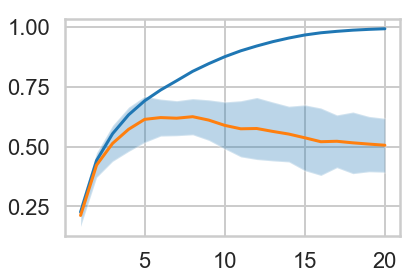

In [30]:
# your code here
# plot means and shade the 2 SD interval
plt.plot(depths, train_scores)
plt.plot(depths, cvmeans)
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3);
# probably wants to go with 6 or 8 depth to avoid overfit

<hr style='height:2px'>

Ok with this discussion in mind, lets improve this model by Bagging.

## Bootstrap-Aggregating (called Bagging)

Whats the basic idea?

- A Single Decision tree is likely to overfit.
- So lets introduce replication through Bootstrap sampling.
- **Bagging** uses bootstrap resampling to create different training datasets. This way each training will give us a different tree.
- Added bonus: the left off points can be used to as a natural "validation" set, so no need to 
- Since we have many trees that we will **average over for prediction**, we can choose a large `max_depth` and we are ok as we will rely on the law of large numbers to shrink this large variance, low bias approach for each individual tree.

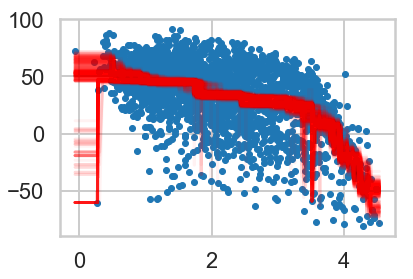

In [33]:
from sklearn.utils import resample

ntrees = 500
estimators = []
R2s = []
yhats_test = np.zeros((Xtest.shape[0], ntrees))

plt.plot(np.log(x),y,'.')
for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=3)
    boot_xx, boot_y = resample(Xtrain[['logminority']], ytrain)
    estimators = np.append(estimators,simpletree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,simpletree.score(Xtest[['logminority']], ytest))
    yhats_test[:,i] = simpletree.predict(Xtest[['logminority']])
    plt.plot(np.log(x), simpletree.predict(np.log(x).reshape(-1,1)), 'red', alpha=0.05)

In [34]:
yhats_test.shape

(614, 500)

<div class="exercise">**Exercise 2**</div>

1. Edit the code below (which is just copied from above) to refit many bagged trees on the entire xtrain feature set (without the plot...lots of predictors now so difficult to plot). 

2. Summarize how each of the separate trees performed (both numerically and visually) using $R^2$ as the metric.  How do they perform on average?

3. Combine the trees into one prediction and evaluate it using $R^2$.

4. Briefly discuss the results.  How will the results above change if 'max_depth=4' is increased?  What if it is decreased?

Aggregated tree is better, the result only improves when max_depth gets higher. Decreased doesn't help

In [43]:
from sklearn.metrics import r2_score


ntrees = 500
estimators = []
R2s = []
yhats_test = np.zeros((Xtest.shape[0], ntrees))

for i in range(ntrees):
    dtree = DecisionTreeRegressor(max_depth=4)
    boot_xx, boot_y = resample(Xtrain, ytrain)
    estimators = np.append(estimators,dtree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,dtree.score(Xtest, ytest))
    yhats_test[:,i] = dtree.predict(Xtest)

# your code here
    


In [39]:
yhats_test.shape 
# each row is observation in test set
# each column is a tree

(614, 500)

(array([  4.,  17.,  26.,  61.,  94., 128.,  98.,  48.,  21.,   3.]),
 array([0.51902   , 0.52975069, 0.54048137, 0.55121206, 0.56194275,
        0.57267344, 0.58340413, 0.59413482, 0.60486551, 0.6155962 ,
        0.62632689]),
 <a list of 10 Patch objects>)

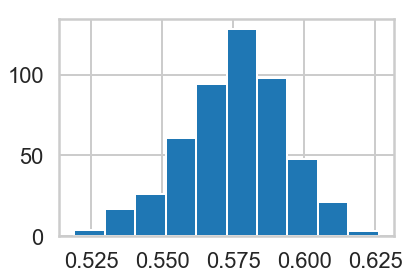

In [44]:
plt.hist(R2s)

In [45]:
y_hats_avg = np.mean(yhats_test, axis=1) # average for all trees

In [46]:
r2_score(ytest, y_hats_avg) # averaging all trees give you better results

0.6511470424230388

In [ ]:
# You want to use number of depths that is marginally higher than the best number of trees (e.g., 8 trees)
# If the average tree is much higher than the individual model score, then you know that each model is very over-fit

#### Your answer here

<hr style='height:2px'>

## Random Forests

What's the basic idea?

Bagging alone is not enough randomization, because even after bootstrapping, we are mainly training on the same data points using the same variablesn, and will retain much of the overfitting.

So we will build each tree by splitting on "random" subset of predictors at each split (hence, each is a 'random tree').  This can't be done in with just one predcitor, but with more predictors we can choose what predictors to split on randomly and how many to do this on.  Then we combine many 'random trees' together by averaging their predictions, and this gets us a forest of random trees: a **random forest**.

Below we create a hyper-param Grid. We are preparing to use the bootstrap points not used in training for validation.

```
max_features : int, float, string or None, optional (default=”auto”)
- The number of features to consider when looking for the best split.
```

- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 
- You can "validate" on the trees `n_estimators` as well but many a times you will just look for the plateau in the trees as seen below.
- From decision trees you get the `max_depth`, `min_samples_split`, and `min_samples_leaf` as well but you might as well leave those at defaults to get a maximally expanded tree.

In [47]:
from sklearn.ensemble import RandomForestRegressor

/Users/pwong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [48]:
# code from 
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
from collections import OrderedDict
param_dict = OrderedDict(
    n_estimators = [400, 600, 800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

param_dict.values()

odict_values([[400, 600, 800], [0.2, 0.4, 0.6, 0.8]])

### Using the OOB score.

We have been putting "validate" in quotes. This is because the bootstrap gives us left-over points! So we'll now engage in our very own version of a grid-search, done over the out-of-bag scores that `sklearn` gives us for free

In [50]:
from itertools import product

In [51]:
#make sure ytrain is the correct data type...in case you have warnings
#print(yytrain.shape,ytrain.shape,Xtrain.shape)
#ytrain = np.ravel(ytrain)

#Let's Cross-val. on the two 'hyperparameters' we based our grid on earlier
results = {}
estimators= {}
for ntrees, maxf in product(*param_dict.values()):
    params = (ntrees, maxf)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=ntrees, max_features=maxf, max_depth=50, n_jobs=-1)
    est.fit(Xtrain, ytrain)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(600, 0.6)

In [52]:
rf1 = estimators[outparams]

In [53]:
results

{(400, 0.2): 0.7538925162894314,
 (400, 0.4): 0.7712862926255044,
 (400, 0.6): 0.7735620174957158,
 (400, 0.8): 0.7715338454739068,
 (600, 0.2): 0.7538234320341135,
 (600, 0.4): 0.7713563301518472,
 (600, 0.6): 0.7744239826830277,
 (600, 0.8): 0.7731883427561539,
 (800, 0.2): 0.7556008456876564,
 (800, 0.4): 0.7719502350812941,
 (800, 0.6): 0.7738404444342093,
 (800, 0.8): 0.7730645518691628}

In [54]:
rf1.score(Xtest, ytest)

0.7823237427667026

Finally you can find the **feature importance** of each predictor in this random forest model. Whenever a feature is used in a tree in the forest, the algorithm will log the decrease in the splitting criterion (such as gini). This is accumulated over all trees and reported in `est.feature_importances_`

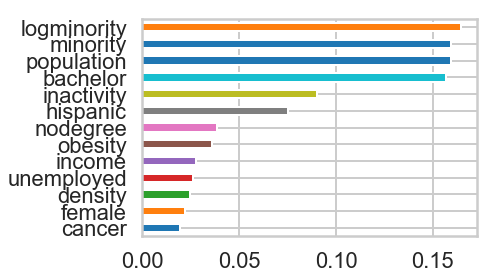

In [55]:
pd.Series(rf1.feature_importances_,index=list(Xtrain)).sort_values().plot(kind="barh")

Since our response isn't very symmetric, we may want to suppress outliers by using the `mean_absolute_error` instead. 

In [56]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, rf1.predict(Xtest))

11.446294812703586

<div class="exercise">**Bonus Exercise (we will likely skip this)**</div>
1. Tune the 'RandomForestRegressor' above to minimize 'mean_absolute_error' instead of the default ____________

*Note: `sklearn` supports this (`criterion='mae'`) since v0.18, but does not have completely arbitrary loss functions for Random Forests.*


In [ ]:
# your code here

<hr style='height:2px'>

Note: instead of using oob scoring, we could do cross-validation, and a cv of 3 will roughly be comparable (same approximate train-vs.-validation set sizes). But this will take much more time as you are doing the fit 3 times plus the bootstraps. So at least three times as long!

In [ ]:
param_dict2 = OrderedDict(
    n_estimators = [600],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

In [ ]:
from sklearn.model_selection import GridSearchCV
est2 = RandomForestRegressor(oob_score=False)
gs = GridSearchCV(est2, param_grid = param_dict2, cv=3, n_jobs=-1)
gs.fit(Xtrain, ytrain)


In [ ]:
rf2 = gs.best_estimator_
rf2

In [ ]:
gs.best_score_

<div class="exercise">**Exercise 3: thinking questions**</div>
1. What are the 3 *hyperparameters* for a random forest (one of the hyperparameters come in many *flavors*)?
2. Which hyperparameters need to be tuned?
3. How would you go about tuning these hyperparemeters?

#### Your answer here
max_depth for any single tree

max_features

num_estimators

<hr style='height:2px'>

### Seeing error as a function of the proportion of predictors at each split

Let's look to see how `max_features` affects performance on the training set.

In [ ]:
# from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

feats = param_dict['max_features']
# 
error_rate = OrderedDict((label, []) for label in feats)

# Range of `n_estimators` values to explore.
min_estimators = 200
step_estimators = 100
num_steps = 3
max_estimators = min_estimators + step_estimators*num_steps
for label in feats:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf = RandomForestRegressor(oob_score=True, max_features=label)
        clf.set_params(n_estimators=i)
        clf.fit(Xtrain, ytrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

In [ ]:
print(feats)

In [ ]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## Boosting Regression Trees

Adaboost Classification, which you will be doing in your homework, is a special case of a gradient-boosted algorithm. Gradient Bossting is very state of the art, and has major connections to logistic regression, gradient descent in a functional space, and search in information space. See Schapire and Freund's MIT Press book for details (Google is a wonderful thing).

But briefly, let us cover the idea here. The idea is that we will use a bunch of weak 'learners' (aka, models) which are fit sequentially. The first one fits the signal, the second one the first model's residual, the third the second model's residual, and so on. At each stage we upweight the places that our previous model did badly on. First let us illustrate.

In [ ]:
# boosting: models for residuals/error from the previous model
# every step improves bias

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
estab = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1), n_estimators=200, learning_rate=1.0)
estab.fit(xx, y)
staged_predict_generator = estab.staged_predict(xx)

In [ ]:
# code from http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb
import time
from IPython import display
plt.plot(xx, y, '.');
counter = 0
for stagepred in staged_predict_generator:
    counter = counter + 1
    if counter in [1, 2, 4, 8, 10, 50, 100, 200]:
        plt.plot(xx, stagepred, alpha=0.7, label=str(counter), lw=4)
        plt.legend();
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)

In [ ]:
print(counter, i)

Ok, so this demonstration helps us understand some things about boosting.

- `n_estimators` is the number of trees, and thus the stage in the fitting. It also controls the complexity for us. The more trees we have the more we fit to the tiny details.
- `staged_predict` gives us the prediction at each step
- once again `max_depth` from the underlying decision tree tells us the depth of the tree. But here it tells us the amount of features interactions we have, not just the scale of our fit. But clearly it increases the variance again.

Ideas from decision trees remain. For example, increase `min_samples_leaf` or decrease `max_depth` to reduce variance and increase the bias.

<div class="exercise">**Exercise 4**</div>
1. What do you expect to happen if you increase `max_depth` to 5?  Edit the code above to explore the result.
2. What do you expect to happen if you put `max_depth` back to 1 and decrease the `learning_rate` to 0.1?  Edit the code above to explore the result.
3. Do a little work to find some sort of 'best' values of `max_depth` and `learning_rate`.  Does this result make sense?

In [ ]:
# your code here

<hr style='height:2px'>

### Note: what's the relationship between residuals and the gradient?

Pavlos showed in class that for the squared loss, taking the gradient in the "data point functional space", ie a N-d space for N data points with each variable being $f(x_i)$ just gives us the residuals. It turns out that the gradient descent is a more general idea, and one can use this for different losses. And the upweighting of poorly fit points in AdaBoost is simply a weighing by gradient. If the gradient (or residual) is high it means you are far away from optimum in this functional space, and if you are at 0, you have a flat gradient!

The ideas from the general theory of gradient descent tell us this: we can slow the learning by shrinking the predictions of each tree by some small number, which is called the learning_rate (learning_rate). This "shrinkage" helps us not overshoot, but for a finite number of iterations also simultaneously ensures we dont overfit by being in the neighboorhood of the minimum rather than just at it! But we might need to increase the iterations some to get into the minimum area.